# Sequential Model-Based Optimization under a Bayesian Approach

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skopt
from sklearn.linear_model import Ridge
from sklearn.datasets import load_digits
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
mpl.rcParams['figure.figsize'] = (16, 8)

In [2]:
NOISE_LEVEL=0.1

## Define a function to minimize

This part is taken from https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [3]:
def f(x, noise_level=NOISE_LEVEL):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

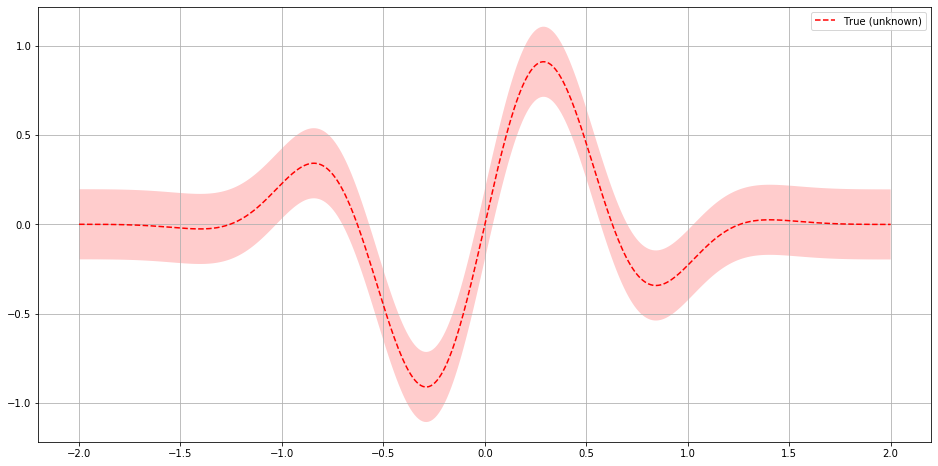

In [21]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * NOISE_LEVEL for fx_i in fx],
                         [fx_i + 1.9600 * NOISE_LEVEL for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

## Minimisation with a gaussian process

In [5]:
# Parameters
N_INITIAL_POINTS = 3
N_ITER = 25
N_PLOTS = 8

In [6]:
%%latex
The criteria we use to define the potential at the point $x$ is called Expected Improvement and is defined as such:
$$EI(x) = E(max(f(x) - f(x^{+})), 0)$$

<IPython.core.display.Latex object>

In [7]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=N_ITER,         # the number of evaluations of f
                  n_random_starts=N_INITIAL_POINTS,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

In [8]:
from skopt.acquisition import gaussian_ei

x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = res.space.transform(x.tolist())
fx = np.array([f(x_i, noise_level=0.0) for x_i in x])

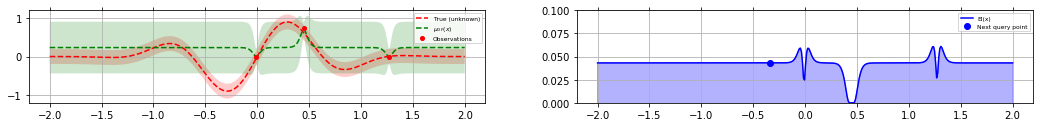

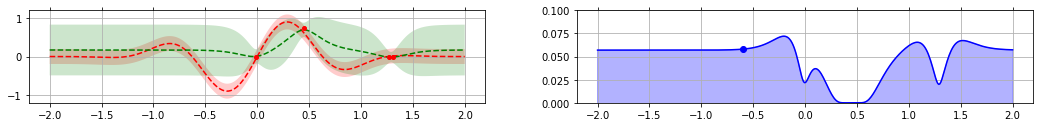

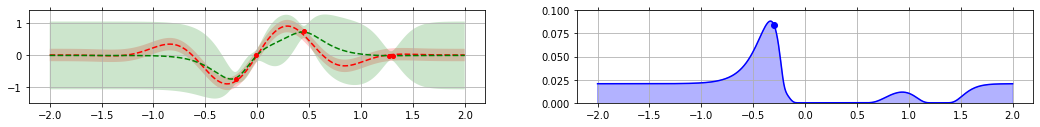

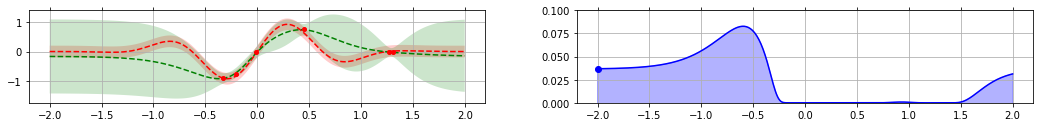

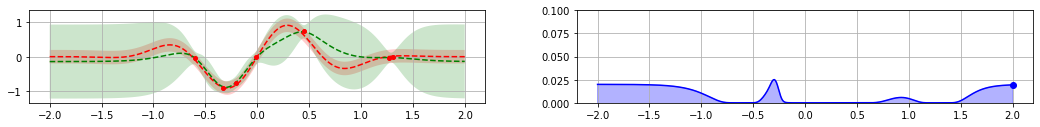

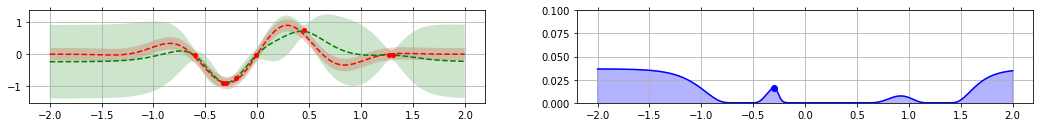

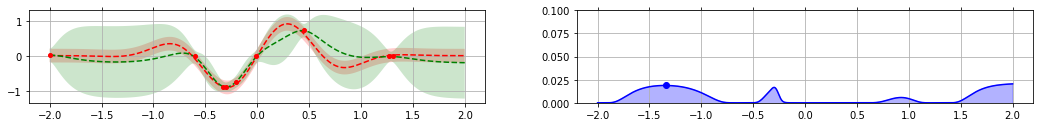

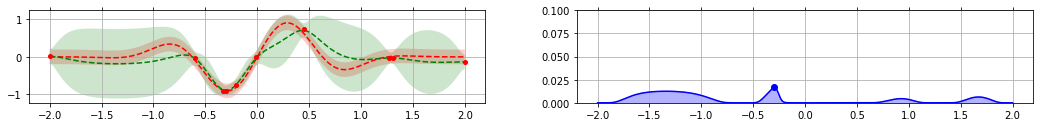

In [9]:
for n_iter in range(N_PLOTS):
    gp = res.models[n_iter]
    curr_x_iters = res.x_iters[:N_INITIAL_POINTS+n_iter]
    curr_func_vals = res.func_vals[:N_INITIAL_POINTS+n_iter]

    # Plot true function.
    plt.figure(figsize=(18, 16))
    plt.subplot(N_PLOTS, 2, 2*n_iter+1)
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * NOISE_LEVEL,
                             fx[::-1] + 1.9600 * NOISE_LEVEL]),
             alpha=.2, fc="r", ec="None")

    # Plot GP(x) + contours
    y_pred, sigma = gp.predict(x_gp, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(curr_x_iters, curr_func_vals,
             "r.", markersize=8, label="Observations")

    # Adjust plot layout
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off',
                        top='off', labelbottom='off')

    # Plot EI(x)
    plt.subplot(N_PLOTS, 2, 2*n_iter+2)
    acq = gaussian_ei(x_gp, gp, y_opt=np.min(curr_func_vals))
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')

    next_x = res.x_iters[5+n_iter]
    next_acq = gaussian_ei(res.space.transform([next_x]), gp,
                           y_opt=np.min(curr_func_vals))
    plt.plot(next_x, next_acq, "bo", markersize=6, label="Next query point")

    # Adjust plot layout
    plt.ylim(0, 0.1)
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off',
                        top='off', labelbottom='off')

plt.show()

## Build toy dataset for BayesSearchCV

In [10]:
X, y = make_regression(n_samples=150, n_features=2)
X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]

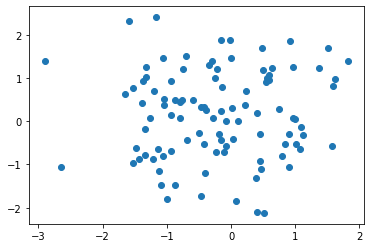

In [11]:
plt.scatter(X_train[:, 0], X_train[:, 1])

## Compare BayesSearchCV and RandomizedSearchCV

In [12]:
bayes_grid = BayesSearchCV(
    Ridge(),
    {
        'alpha': (0, 10, 'uniform')
    },
    n_iter=20,
    cv=3
)

In [13]:
bayes_grid.fit(X_train, y_train)

/Users/thomaspesneau/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/thomaspesneau/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/thomaspesneau/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/thomaspesneau/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/thomaspesneau/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this p

BayesSearchCV(cv=3, error_score='raise',
              estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                              max_iter=None, normalize=False, random_state=None,
                              solver='auto', tol=0.001),
              fit_params=None, iid=True, n_iter=20, n_jobs=1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False, scoring=None,
              search_spaces={'alpha': (0, 10, 'uniform')}, verbose=0)

In [14]:
bayes_grid.best_score_

1.0

In [15]:
random_grid = RandomizedSearchCV(
    Ridge(),
    {
        'alpha': stats.uniform(0, 10)
    },
    n_iter=20,
    cv=3)

In [16]:
random_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='warn', n_iter=20, n_jobs=None,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1a7a4c88>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [17]:
random_grid.best_score_

0.9998968900046856

In [18]:
print("MSE for bayes grid: {}".format(mean_squared_error(bayes_grid.best_estimator_.fit(X_train, y_train).predict(X_test), y_test)))

MSE for bayes grid: 9.616309097952761e-27


In [19]:
print("MSE for random grid: {}".format(mean_squared_error(random_grid.best_estimator_.fit(X_train, y_train).predict(X_test), y_test)))

MSE for random grid: 0.27596846300398353
